In [29]:
import numpy as np
import pandas as pd
import json 
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import ast
from collections import Counter
from scipy.stats import pearsonr

In [30]:
import xgboost
from sklearn.metrics import mean_squared_error
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

# Read Data

In [167]:
train = pd.read_csv('train.csv', header=0)#,nrows=100)
export_csv = train.to_csv (r'export_dataframe.csv', index = None, header=True)

dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train = text_to_dict(train)
train.shape



(3000, 23)

# Clean Data From Unkown and Not logical  Vlaues 

In [168]:
train.loc[ (train['budget'] < 3000),'budget'] = 0
train.loc[ (train['revenue'] < 3000),'revenue'] = 0
train = train[(train[['budget']] != 0).all(axis = 1)]
train = train[(train[['revenue']] != 0).all(axis = 1)]
train = train[(train[['budget']] != 0).all(axis=1)]
train = train[(train[['runtime']] != 0).all(axis=1)]
train.shape

(2151, 23)

# Extract Features 

In [169]:
train['has_collection'] = 1
train.loc[pd.isnull(train['belongs_to_collection']) ,"has_collection"] = 0
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).astype(int)
    
# Some rows have 2 digits of year instead of 4
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

train['isOriginalLanguageEng'] = 0 
train.loc[ train['original_language'] == "en" ,"isOriginalLanguageEng"] = 1

train['has_homepage'] = 1
train.loc[pd.isnull(train['homepage']) ,"has_homepage"] = 0

train['_popularity_mean_year'] = train['popularity'] / train.groupby("release_year")["popularity"].transform('mean')
train['_budget_runtime_ratio'] = train['budget']/train['runtime'] 
train['_budget_popularity_ratio'] = train['budget']/train['popularity']
train['_budget_year_ratio'] = train['budget']/(train['release_year']*train['release_year'])
train['_releaseYear_popularity_ratio'] = train['release_year']/train['popularity']
train['_releaseYear_popularity_ratio2'] = train['popularity']/train['release_year']

train.replace([np.inf, -np.inf], np.nan)
train.dropna()
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'].replace(" ", "") for i in x])) if x != {} else '')
train['production_countries_count']=train['all_countries'].apply(lambda x:len(x.split()))

# cast_count

train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'].replace(" ", "") for i in x])) if x != {} else '')
train['cast_count']=train['all_cast'].apply(lambda x:len(x.split()))

# production_companies_count

train['all_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'].replace(" ", "") for i in x])) if x != {} else '')
train['production_companies_count']=train['all_companies'].apply(lambda x:len(x.split()))
train['production_companies_count'].isna().sum()
# crew_count
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'].replace(" ", "") for i in x])) if x != {} else '')
train['crew_count']=train['all_crew'].apply(lambda x:len(x.split()))

#keywords
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'].replace(" ", "") for i in x])) if x != {} else '')
train['Keywords_count']=train['all_Keywords'].apply(lambda x:len(x.split()))

x = train.groupby("release_year")["budget"].aggregate('mean')
train['meanBudgetByYear'] = train['release_year'].apply(lambda y: x[y] )

x = train.groupby("release_year")["runtime"].aggregate('mean')
train['meanruntimeByYear'] = train['release_year'].apply(lambda y: x[y] )
x = train.groupby("release_year")["popularity"].aggregate('mean')
train['meanPopularityByYear'] = train['release_year'].apply(lambda y: x[y] )

x = train.groupby("release_year")["budget"].aggregate('mean')                                                            
train['meanBudgetByYear'] = train['release_year'].apply(lambda y: x[y] )
train = train[(train[['budget']] != 0).all(axis=1)]
train_temp=train
train.shape                                                      
#train = train.drop(['id','belongs_to_collection','genres','homepage','imdb_id','overview','runtime','poster_path','production_companies','production_countries','release_date','spoken_languages','status','title','Keywords','cast','crew','original_language','original_title','tagline'],axis=1)

(2151, 50)

In [170]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
#print(train['production_companies'].head)
most_companies= Counter([i for j in list_of_companies for i in j]).most_common(25)
train['most_companies']=0
train['all_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(25)]
for g in top_companies:
    train['company_' + g] = train['all_companies'].apply(lambda x: 1 if g in x else 0)
for g in top_companies:
    train['most_companies']+=train['company_' + g]
    train = train.drop(['company_' + g],axis=1)
train['most_companies'] = train['most_companies'].apply(lambda x: 1 if x>0 else 0)

In [171]:
#print(train['production_countries'].head)
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(Counter([i for j in list_of_countries for i in j]).most_common(5))
train['most_countries']=0
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(13)]
for g in top_countries:
    train['country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
for g in top_countries:
    train['most_countries']+=train['country_' + g]
    train = train.drop(['country_' + g],axis=1)
train['most_countries'] = train['most_countries'].apply(lambda x: 1 if x>0 else 0)

[('United States of America', 1764), ('United Kingdom', 263), ('France', 147), ('Germany', 128), ('Canada', 94)]


# Relation between features and Target (Revenue)

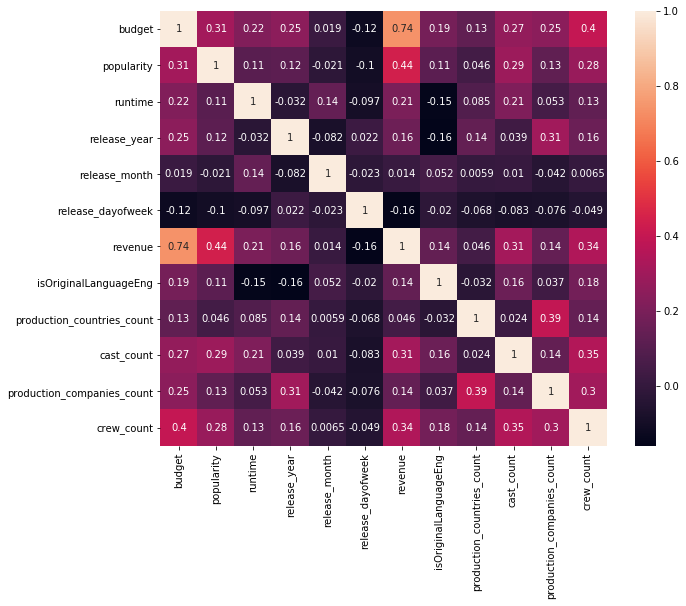

In [36]:

tmp = train[['budget','popularity','runtime','release_year','release_month','release_dayofweek','revenue','isOriginalLanguageEng', 'production_countries_count' ,'all_cast','cast_count' ,'production_companies_count', 'crew_count']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tmp.corr(), annot=True)
plt.show()

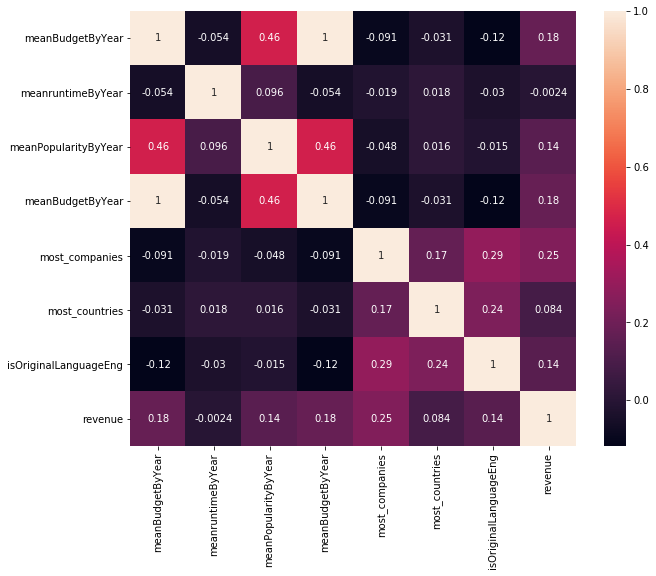

In [37]:
tmp = train[['meanBudgetByYear','meanruntimeByYear','meanPopularityByYear','meanBudgetByYear','most_companies','most_countries','isOriginalLanguageEng','revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tmp.corr(), annot=True)
plt.show()


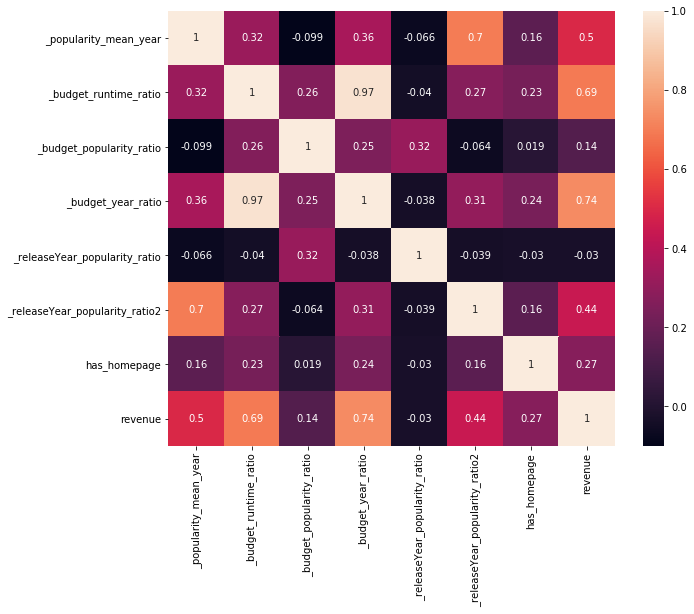

In [38]:
tmp = train.dropna()
tmp = train[['_popularity_mean_year','_budget_runtime_ratio','_budget_popularity_ratio','_budget_year_ratio','_releaseYear_popularity_ratio','_releaseYear_popularity_ratio2','has_homepage','revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tmp.corr(), annot=True)
plt.show()
    
   

# lightgbm Model

In [172]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y,verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    pred= model.predict(val_x)
    y_predict=np.log(pred)
    y_real=np.log(val_y)
    # Calculate the Root Mean Squared Error
    #print("RMSE: %.2f"% np.sqrt(mean_squared_error(np.log(regr.predict(X_test)), np.log(y_test))))
    print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))
    #return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}


# Linear Regression , XGB , LGB Models  with features
cast_count , crew count , _popularity_mean_year ,_budget_year_ratio

In [196]:
train_data = pd.DataFrame(np.c_[train['revenue'],train['cast_count'],train['crew_count'],train['_popularity_mean_year'],train['_budget_year_ratio']], columns = ['revenue','cast_count', 'crew_count','_popularity_mean_year','_budget_year_ratio'])
output= train_data['revenue']
train_data = train_data.drop(['revenue'],axis=1)
train_data.shape

(2151, 4)

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_data, output,test_size=0.2)
regr.fit(X_train, y_train)
y_predict=np.log(regr.predict(X_test))
y_real=np.log(y_test)
# Calculate the Root Mean Squared Error
#print("RMSE: %.2f"% np.sqrt(mean_squared_error(np.log(regr.predict(X_test)), np.log(y_test))))
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))

RMSE: 1.57


/home/reham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [198]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,  colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
predictions = xgb.predict(X_test)
y_predict=np.log(predictions)
y_real=np.log(y_test)
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))
print(explained_variance_score(predictions,y_test))

RMSE: 1.75
0.1937297490814346


/home/reham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [199]:
lgb_model(X_train, y_train, X_test, y_test, 0)

RMSE: 1.77


# Linear Regression , XGB  Models  with features
_budget_runtime_ratio ,crew count , _popularity_mean_year ,_budget_year_ratio

In [206]:
train_data = pd.DataFrame(np.c_[train['revenue'],train['_budget_runtime_ratio'],train['crew_count'],train['_popularity_mean_year'],train['_budget_year_ratio']], columns = ['revenue','_budget_runtime_ratio', 'crew_count','_popularity_mean_year','_budget_year_ratio'])
train_data=train_data.dropna()
output= train_data['revenue']
train_data = train_data.drop(['revenue'],axis=1)
train_data.shape

(2150, 4)

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_data, output,test_size=0.2)
regr.fit(X_train, y_train)
y_predict=np.log(regr.predict(X_test))
y_real=np.log(y_test)
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))

RMSE: 1.69


/home/reham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [208]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,  colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
predictions = xgb.predict(X_test)
#print("RMSE: %.2f"% np.sqrt(np.log(mean_squared_error(predictions, y_test))))
y_predict=np.log(predictions)
y_real=np.log(y_test)
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))
print(explained_variance_score(predictions,y_test))

RMSE: 1.73
0.4303927095823671


/home/reham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [209]:
lgb_model(X_train, y_train, X_test, y_test, 0)

RMSE: 1.90


# Take all Features that have high correlation with Target

In [210]:
train_data = train[['revenue','budget','popularity','runtime','release_year','release_month','isOriginalLanguageEng', 'production_countries_count' ,'cast_count' ,'production_companies_count', 'crew_count','_popularity_mean_year','_budget_runtime_ratio','_budget_popularity_ratio','_budget_year_ratio','_releaseYear_popularity_ratio2','has_homepage']]
train_data=train_data.dropna()
y = train_data['revenue']
train_data = train_data.drop(['revenue'],axis=1)
X = train_data
train_data.shape
#X_train, X_test, y_train, y_test = train_test_split(train_data, output,test_size=0.2)

(2150, 16)

# Make Forward-BackWard Feature Selection

In [211]:

from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)
result.append('revenue')
print('resulting features:')
print(result)

/home/reham/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/reham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  budget                         with p-value 0.0
Add  _popularity_mean_year          with p-value 5.73898e-72
Add  _budget_year_ratio             with p-value 1.23029e-12
Add  production_companies_count     with p-value 3.62118e-09
Add  _budget_runtime_ratio          with p-value 1.14448e-08
Add  has_homepage                   with p-value 8.98262e-06
Add  _releaseYear_popularity_ratio2 with p-value 8.15244e-05
Add  cast_count                     with p-value 0.00220486
resulting features:
['budget', '_popularity_mean_year', '_budget_year_ratio', 'production_companies_count', '_budget_runtime_ratio', 'has_homepage', '_releaseYear_popularity_ratio2', 'cast_count', 'revenue']


In [212]:
train_data = train[result]
train_data=train_data.dropna()
y = train_data['revenue']
train_data = train_data.drop(['revenue'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_data, y,test_size=0.2)
train_data.shape

(2150, 8)

In [224]:
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_data, output,test_size=0.2)
regr.fit(X_train, y_train)
y_predict=np.log(regr.predict(X_test))
y_real=np.log(y_test)
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))

RMSE: 1.52


/home/reham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [225]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,  colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
predictions = xgb.predict(X_test)
y_predict=np.log(predictions)
y_real=np.log(y_test)
print("RMSE: %.2f"% math.sqrt(np.mean((y_predict - y_real)** 2)))
print(explained_variance_score(predictions,y_test))

/home/reham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 1.59
0.577588518960277


In [227]:
lgb_model(X_train, y_train, X_test, y_test, 0)

RMSE: 1.74
